Feature importance, hyperparameter tuning and further usage of a ml model
======================


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from numpy import sort
import seaborn as sns
from sklearn.externals import joblib
# from pdpbox import pdp

plt.style.use('ggplot')

data = pd.read_csv('avocado.csv')
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Feature engineering and data cleaning
==============================
This dataset is already fairly good, so we do not really have to do any cleaning. Often you will be working with a lot more messy datasets and multiple datasets that have to be merged. We will still have to do a litte feature engineering to get more out of our dataset.



In [2]:
data['Date'] = pd.to_datetime(data.Date)

In [3]:
data['day_of_week'] = data['Date'].dt.weekday_name

In [4]:
data.day_of_week.unique()

array(['Sunday'], dtype=object)

In [5]:
data['month'] = data['Date'].dt.month

In [6]:
data['day'] = data['Date'].dt.day

In [7]:
data = data.rename(columns={'Unnamed: 0': 'Store'})

Understanding the dataset
====================

Unique values of categorical data. It can be useful to know how many unique values you have in your text data, for picking the way of making your categorical data into numrical data.

<h2>About this Dataset</h2>
<h4>Context</h4>

It is a well known fact that Millenials LOVE Avocado Toast. It's also a well known fact that all Millenials live in their parents basements.

Clearly, they aren't buying home because they are buying too much Avocado Toast!

But maybe there's hope... if a Millenial could find a city with cheap avocados, they could live out the Millenial American Dream.

Content

This data was downloaded from the Hass Avocado Board website in May of 2018 & compiled into a single CSV. Here's how the Hass Avocado Board describes the data on their website:

> The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

<h4>Some relevant columns in the dataset:</h4>

Date - The date of the observation
AveragePrice - the average price of a single avocado
type - conventional or organic
year - the year
Region - the city or region of the observation

Numerical column names refer to price lookup codes.

4046:  small Hass

4225:  large Hass

4770:  extra large Hass

Therefore for easier reading of our dataset, we can rename the columns with lookup codes as names.

In [8]:
data = data.rename(columns={'4046': 'small Hass', '4225':  'large Hass', '4770':  'extra large Hass'})

In [9]:
print('Unique values in columns with text:\n\n Dates: {0} \n\n Data type: {1} \n\n Year: {2} \n\n Region: {3} \n\n Day of week: {4} \n\n Month: {5}'.format(data.Date.unique(), data.type.unique(), data.year.unique(), data.region.unique(), data['day_of_week'].unique(), data.month.unique()))

Unique values in columns with text:

 Dates: ['2015-12-27T00:00:00.000000000' '2015-12-20T00:00:00.000000000'
 '2015-12-13T00:00:00.000000000' '2015-12-06T00:00:00.000000000'
 '2015-11-29T00:00:00.000000000' '2015-11-22T00:00:00.000000000'
 '2015-11-15T00:00:00.000000000' '2015-11-08T00:00:00.000000000'
 '2015-11-01T00:00:00.000000000' '2015-10-25T00:00:00.000000000'
 '2015-10-18T00:00:00.000000000' '2015-10-11T00:00:00.000000000'
 '2015-10-04T00:00:00.000000000' '2015-09-27T00:00:00.000000000'
 '2015-09-20T00:00:00.000000000' '2015-09-13T00:00:00.000000000'
 '2015-09-06T00:00:00.000000000' '2015-08-30T00:00:00.000000000'
 '2015-08-23T00:00:00.000000000' '2015-08-16T00:00:00.000000000'
 '2015-08-09T00:00:00.000000000' '2015-08-02T00:00:00.000000000'
 '2015-07-26T00:00:00.000000000' '2015-07-19T00:00:00.000000000'
 '2015-07-12T00:00:00.000000000' '2015-07-05T00:00:00.000000000'
 '2015-06-28T00:00:00.000000000' '2015-06-21T00:00:00.000000000'
 '2015-06-14T00:00:00.000000000' '2015-06-07T

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 17 columns):
Store               18249 non-null int64
Date                18249 non-null datetime64[ns]
AveragePrice        18249 non-null float64
Total Volume        18249 non-null float64
small Hass          18249 non-null float64
large Hass          18249 non-null float64
extra large Hass    18249 non-null float64
Total Bags          18249 non-null float64
Small Bags          18249 non-null float64
Large Bags          18249 non-null float64
XLarge Bags         18249 non-null float64
type                18249 non-null object
year                18249 non-null int64
region              18249 non-null object
day_of_week         18249 non-null object
month               18249 non-null int64
day                 18249 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(4), object(3)
memory usage: 2.4+ MB


Handeling categorical data
=====================

I am choosing to handle categorical data, by replacing 

In [11]:
mappings_type = {'conventional':0, 'organic':1}

mappings_dayofweek = {'Sunday':1}

mappings_region = {}

v = 0

regions = list(data.region.unique())

numbers = []

for i in regions:
    v = v+1
    numbers.append(v)

d = zip(regions, numbers)

mappings_region = dict(d)

data.type.replace(mappings_type, inplace=True)
data.day_of_week.replace(mappings_dayofweek, inplace=True)
data.region.replace(mappings_region, inplace=True)

In [12]:
data.head()

,Store,Date,AveragePrice,Total Volume,small Hass,large Hass,extra large Hass,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,day_of_week,month,day
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,0,2015,1,1,12,27
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,0,2015,1,1,12,20
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,0,2015,1,1,12,13
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,0,2015,1,1,12,6
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,0,2015,1,1,11,29


<h2>Descriptive statistics</h2>
Describtive statistics is crusial to understand your dataset properly. Descriptive statistics is the first step to perform good prescriptive and predictive statistics.

In [13]:
data.describe()

,Store,AveragePrice,Total Volume,small Hass,large Hass,extra large Hass,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,day_of_week,month,day
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000,18249.000000,18249.000000,18249.0,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,0.499918,2016.147899,27.495644,1.0,6.177215,15.662612
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.500014,0.939938,15.583788,0.0,3.534130,8.776281
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,2015.000000,1.000000,1.0,1.000000,1.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,0.000000,2015.000000,14.000000,1.0,3.000000,8.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,0.000000,2016.000000,27.000000,1.0,6.000000,16.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,1.000000,2017.000000,41.000000,1.0,9.000000,23.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,1.000000,2018.000000,54.000000,1.0,12.000000,31.000000


In [14]:
skew_df = pd.DataFrame(data.skew(), columns={'Skewness'})
skew_df

,Skewness
Store,0.108334
AveragePrice,0.580303
Total Volume,9.007687
small Hass,8.648220
large Hass,8.942466
extra large Hass,10.159396
Total Bags,9.756072
Small Bags,9.540660
Large Bags,9.796455
XLarge Bags,13.139751


In [15]:
kurt_df = pd.DataFrame(data.kurtosis(), columns={'Kurtosis'})
kurt_df

,Kurtosis
Store,-1.254364
AveragePrice,0.325196
Total Volume,92.104458
small Hass,86.809113
large Hass,91.949022
extra large Hass,132.563441
Total Bags,112.272156
Small Bags,107.012885
Large Bags,117.999481
XLarge Bags,233.602612


<h2>Summarize / What do we know now?</h2>

Building our model
===============
___________
Now it is finnaly time for some fun! We will be building a XGBoost model and plotting feature importance of it, to learn some more about our data.

In [16]:
X = data.drop(['AveragePrice', 'Date'], axis=1)

y = data['AveragePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = XGBRegressor(n_jobs=4)
model.fit(X_train, 
            y_train,
            verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [17]:
predictions = model.predict(X_test)
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=5)
print(scores)
print('Mean Absolute Error: %2f' %(-1 * scores.mean()))

[-0.14888892 -0.15173764 -0.17531245 -0.23578806 -0.27182656]
Mean Absolute Error: 0.196711


In [18]:
mae = mean_absolute_error(predictions, y_test)
print("Mean Absolute Error : " + str(mae))

error_percent = mae/data['AveragePrice'].mean()*100
print(str(error_percent) + ' %')

Mean Absolute Error : 0.1520224781418765
10.81257557618608 %


Feature Selection
=============
Selecting the right amount of features, and selecting the right features is crucial to avoid data leakage, overfitting or overfitting.

Therefore we can now do feature importance plot.

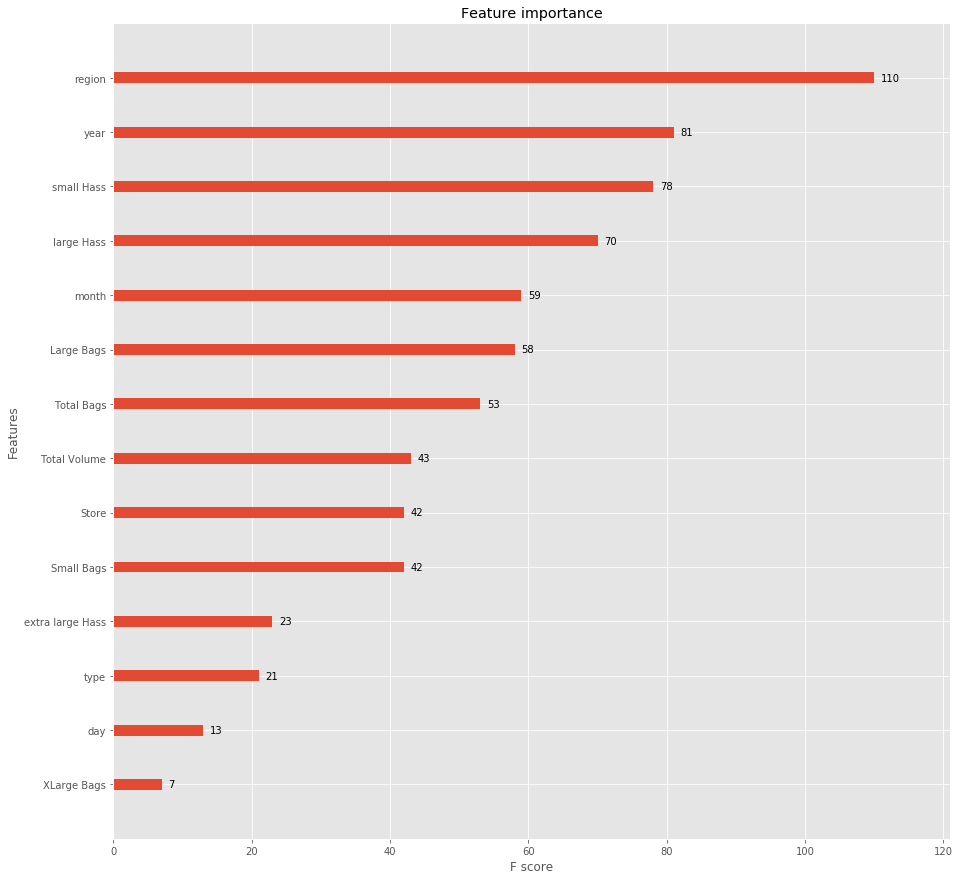

In [19]:
# plot feature importance
fig, ax = plt.subplots(figsize=(15, 15))
imp_plt = plot_importance(model, ax=ax)

In [20]:
# features_to_plot = ['region', 'year']
# inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=X.columns.tolist(), features=features_to_plot)

# pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')

# # Create the data that we will plot
# pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X.columns.tolist(), feature='month')

# # plot it
# pdp.pdp_plot(pdp_goals, 'Month')

# # Create the data that we will plot
# pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X.columns.tolist(), feature='year')

# # plot it
# pdp.pdp_plot(pdp_goals, 'Year')

# # Create the data that we will plot
# pdp_goals = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X.columns.tolist(), feature='region')

# # plot it
# pdp.pdp_plot(pdp_goals, 'Region')
# plt.show()

In [21]:
row_to_show = 5
data_for_prediction = X

In [22]:
# import shap  # package used to calculate Shap values

# # Create object that can calculate shap values
# explainer = shap.TreeExplainer(model)

# # Calculate Shap values
# shap_values = explainer.shap_values(data_for_prediction)



We now know how the model ranks the features, meaning which is the most important features.

Now performing feature selection with scikit learn, can give us a better insight, in how many features might be the optimal number of features to include.

In [23]:
mae = mean_absolute_error(predictions, y_test)
error_percent = mae/data['AveragePrice'].mean()*100

accuracy = mean_absolute_error(predictions, y_test)
print("Mean Absolute Error : " + str(mae) + "\t" + str(error_percent) + ' %')

#scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=5)
#print(scores)
#print('Mean Absolute Error: %2f' %(-1 * scores.mean()))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)

best_score = {}

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor(n_jobs=4)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    #print('Mean Absolute Error: %2f' %(-1 * scores.mean()))
    accuracy = mean_absolute_error(predictions, y_test)
    mae = mean_absolute_error(predictions, y_test)
    error_percent = mae/data['AveragePrice'].mean()*100
    #print("Thresh={0:f}, n={1:f}, Accuracy: {2:f}, Mean Absolute Error {3:f}: , err_perct: {4:f}%".format(thresh, select_X_train.shape[1], accuracy * 100, mae, error_percent))
    
    best_score[select_X_train.shape[1]] = str(error_percent) + ' %'

    
print(best_score)

Mean Absolute Error : 0.1520224781418765	10.81257557618608 %
{15: '10.81257557618608 %', 14: '10.81257557618608 %', 13: '10.799142640354495 %', 12: '10.89251096264245 %', 11: '11.328419198455274 %', 10: '11.381662565845224 %', 8: '11.519667921012552 %', 7: '11.559528378587792 %', 6: '11.9964178853038 %', 5: '12.358680709902766 %', 4: '13.494062739335327 %', 3: '14.288356258835549 %', 2: '21.164435234238578 %', 1: '21.406595495456905 %'}


In [24]:
value = best_score.values()
key = best_score.keys()

min_val = min(value)
min_key = min(best_score, key=best_score.get)
print('Best amout of features: key: {0}, value: {1}'.format(min_key, min_val))

Best amout of features: key: 13, value: 10.799142640354495 %


We can now see that the best amount of features corresponding to the feature selection we just did, is 13. We do know which features is the most important from our feature importance plot, this means we can include top 13 features, for building a more optimized model.
______________________

Building a better model
==================
Now that we know which features is the most important ones, and we know which might possible be the best number of features to include. We can build an optimized model, and let it find the best hyper parameters using cross-validation.

--------
We start by selscting the data we need.

In [25]:
X_opt = data.drop(['AveragePrice', 'Date', 'XLarge Bags'], axis=1)
y_opt = data['AveragePrice']

opt_X_train, opt_X_test, opt_y_train, opt_y_test = train_test_split(X_opt, y_opt, test_size=0.33, random_state=42)

Now that we have the data, we can build our pipeline, using gridsearch cv to find the best hyperparameters.

In [26]:
opt_pipeline = Pipeline([('xgb', XGBRegressor(n_jobs=4))])

param_grid = {
    "xgb__n_estimators": [100, 250, 500, 1000],
    "xgb__learning_rate": [0.1, 0.25, 0.5, 1],
    "xgb__max_depth": [6, 7, 8],
    "xgb__min_child_weight": [0.25, 0.5, 1, 1.5]
}

fit_params = {"xgb__eval_set": [(opt_X_test, opt_y_test)], 
              "xgb__early_stopping_rounds": 10, 
              "xgb__verbose": False} 

searchCV = GridSearchCV(opt_pipeline, cv=5, param_grid=param_grid, fit_params=fit_params)
searchCV.fit(opt_X_train, opt_y_train)

/home/max/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params={'xgb__eval_set': [(       Store  Total Volume   small Hass   large Hass  extra large Hass  \
8604       6     218329.70     79239.58     26356.05           2998.74
2608       8     391514.43    228324.13     72749.38            100.62
14581     48       3907.40      1147.09        ...eragePrice, Length: 6023, dtype: float64)], 'xgb__early_stopping_rounds': 10, 'xgb__verbose': False},
       iid='warn', n_jobs=None,
       param_grid={'xgb__n_estimators': [100, 250, 500, 1000], 'x

In [27]:
searchCV.best_params_

{'xgb__learning_rate': 0.1,
 'xgb__max_depth': 7,
 'xgb__min_child_weight': 0.25,
 'xgb__n_estimators': 1000}

In [28]:
searchCV.cv_results_['mean_train_score']

/home/max/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([0.93300274, 0.97062604, 0.98756294, 0.99239473, 0.93300274,
       0.97062604, 0.98756294, 0.99239473, 0.93300274, 0.97062604,
       0.98756294, 0.99239473, 0.93387919, 0.97070323, 0.98755524,
       0.99005719, 0.96081643, 0.98566642, 0.99461515, 0.99502859,
       0.96081643, 0.98566642, 0.99461515, 0.99502859, 0.96081643,
       0.98566642, 0.99461515, 0.99502859, 0.96124856, 0.98481224,
       0.99402574, 0.99577002, 0.97899288, 0.99367461, 0.99821771,
       0.998396  , 0.97899288, 0.99367461, 0.99821771, 0.998396  ,
       0.97899288, 0.99367461, 0.99821771, 0.998396  , 0.97816855,
       0.99342704, 0.99815538, 0.99837799, 0.96956122, 0.98846413,
       0.98926326, 0.98926326, 0.96956122, 0.98846413, 0.98926326,
       0.98926326, 0.96956122, 0.98846413, 0.98926326, 0.98926326,
       0.96908662, 0.98983526, 0.99088792, 0.99088792, 0.98418067,
       0.99460168, 0.99469401, 0.99469401, 0.98418067, 0.99460168,
       0.99469401, 0.99469401, 0.98418067, 0.99460168, 0.99469

In [29]:
searchCV.cv_results_['mean_test_score']

array([0.87941149, 0.90325073, 0.91110953, 0.91278063, 0.87941149,
       0.90325073, 0.91110953, 0.91278063, 0.87941149, 0.90325073,
       0.91110953, 0.91278063, 0.88132106, 0.90397772, 0.91135892,
       0.91235414, 0.89577399, 0.90963183, 0.91386233, 0.91403434,
       0.89577399, 0.90963183, 0.91386233, 0.91403434, 0.89577399,
       0.90963183, 0.91386233, 0.91403434, 0.89513885, 0.908714  ,
       0.91307452, 0.91388443, 0.90286966, 0.91034949, 0.91264849,
       0.91277454, 0.90286966, 0.91034949, 0.91264849, 0.91277454,
       0.90286966, 0.91034949, 0.91264849, 0.91277454, 0.9030164 ,
       0.91121508, 0.9136555 , 0.91374285, 0.89586131, 0.9027632 ,
       0.90310086, 0.90310086, 0.89586131, 0.9027632 , 0.90310086,
       0.90310086, 0.89586131, 0.9027632 , 0.90310086, 0.90310086,
       0.89650807, 0.90397543, 0.90446821, 0.90446821, 0.9020847 ,
       0.90563019, 0.9056653 , 0.9056653 , 0.9020847 , 0.90563019,
       0.9056653 , 0.9056653 , 0.9020847 , 0.90563019, 0.90566

In [30]:
searchCV.cv_results_['mean_train_score'].mean(), searchCV.cv_results_['mean_test_score'].mean()

/home/max/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


(0.9708920840078304, 0.8686018582966984)

In [31]:
opt_predictions = searchCV.predict(opt_X_test)

In [32]:
mae = mean_absolute_error(opt_predictions, opt_y_test)
print("Mean Absolute Error : " + str(mae))

error_percent = mae/data['AveragePrice'].mean()*100
print("Error percentage: " + str(error_percent) + ' %')

Mean Absolute Error : 0.0788259887810108
Error percentage: 5.606486432005447 %


As we can see We have actually improved our model quite a bit, just with this basic optimazation and feature selection

features_to_plot = ['region', 'year']
inter1  =  pdp.pdp_interact(model=searchCV, dataset=opt_X_test, model_features=X_opt.columns.tolist(), features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')

Futher Usage Of The Model
=====================
-----------------
We can now use our model in other applications, by saving it and loading it in another python program. You can also build an API with it and the include it in an app, on a website, a bigger production system etc.


Lets go ahead and save the model.

In [33]:
# joblib.dump(searchCV, "xgboostmodel.joblib.dat")

For further information on how to load it into another application, lookup saving Gradient Boosting Models with joblib.